## ENEL 645 - Assignment 2

#### Group 8 Team Members
Steve Andersen
<br>David Zarinski
<br>Florian Bache
<br>Eugene Lok

#### Sources
Code contained in this notebook is adapted from the following sources:
<br>https://github.com/rmsouza01/deep-learning/blob/master/JNotebooks/garbage_classifier_images_w2023.ipynb
<br>https://pytorch.org/vision/main/auto_examples/plot_transforms.html

## Why use transfer learning?

There are a few main benefits to using transfer learning:

1. Can leverage an existing **pre-trained model** which has been proven to work on problems similar to our own - transfer learinnig offers a better starting point.
2. Can leverage a working model which has **already learned** patterns on similar data to our own. This often results in achieving **great results with less custom data**.
3. With better starting point and learning rate, transfer learning enables a more accurate output by providing a machine learning model to converge at a higher performance level.
4. Since we are leveraging a pre-trainend model, the learning can achieve faster training than traditional methods (however performance may not be much higher than traditional methods).  [Source: Kaggle.com](https://www.kaggle.com/general/291011)



*We'll be putting these to the test for our Chemotherapy Extravasation problem, we'll take a computer vision model pretrained on ImageNet and try to leverage its underlying learned representations for classifying images of normal, mild, moderate, and severe extravasation injuries.*

Some of the main applications of Transfer learning include:
* Natural Language Processing (NLP)
* Computer Vision (CV)
* Neural Networks
* Gaming Industry


### The Future of Transfer Learning
Although many of the big *breakthroughs* in AI have been the result of using "Big-Data", there are situations where large datasets are not available - an example could be a remote village where medical issues are recorded at a high level but images and labels for the issue are not readily available (or practical to capture/store).

The limited datasets, or "small-data" can still be used using transfer learning by selecting a model that has been pre-trained on a larger, similar dataset, and then retraining the model slightly with the smaller dataset to address the specific problem.

### The Extravasation dataset contains a total of 84 images, pre-classified into normal, mild, moderate, and severe classes.



## Mount drive for Google CoLab

In [1]:
#from google.colab import drive
#drive.mount("/content/drive")

## Lets now import all the necessary modules....

In [2]:
import torch
import glob
import matplotlib.pylab as plt
from torch.utils.data import Dataset
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms, models
from sklearn.model_selection import StratifiedShuffleSplit
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

## Now let's setup device agnostic code.

> **Note:** If you're using Google Colab, and you don't have a GPU turned on yet, you can turn one on via `Runtime -> Change runtime type -> Hardware accelerator -> GPU`.

In [3]:
# Check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cpu


## Defining a custom class in PyTorch
Below we will explore defining a custom class in PyTorch and how to inherit from an exisiting class. In addition, we will define the constructor and some methods for getting the length of the dataset and retrieving an image and its corresponding label. This custom class will provide us with a convenient way to load and preprocess image data which we will use later within our deep learning model. 

In [4]:
# Define the class and inherit from the Dataset class
class TorchVisionDataset(Dataset):

    # Constructor which specifies the filepaths, their corresponding labels and an optional transformation fucntion
    def __init__(self,data_dic, transform = None):
        self.file_paths = data_dic["X"]
        self.labels = data_dic["Y"]
        self.transform = transform

    # Method used to return length of dataset
    def __len__(self):
        return len(self.file_paths)

    # Method used to retrive a single image and its corresponding label contained by the dataset
    def __getitem__(self,idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]

        # lazily open image
        image = Image.open(file_path)

        # convert to rgb
        image = image.convert("RGB")

        # optional data transformation of the image
        if self.transform:
            image = self.transform(image)
        return image, label



## Examine the dataset

Let's take a look at our dataset. We will load the dataset and determine how many images it contains, what the labels are and determine the amount of images for each label.

In [5]:
# Find all image filepaths within the source directory and store them in an array.
images = glob.glob("images/*/*")
images = np.array(images)

# Generate an array of labels by labeling each image based on their parent directory name
labels = np.array([f.split("\\")[-2] for f in images])

In [6]:
# Let's display the the amount of images using len function and the size attribute.
print(len(images))
print(labels.size)

84
84


In [7]:
# Let's display the filepath and label for the 10th image in the dataset.
print(images[9])
print(labels[9])

images\0_normal\normal1.png
0_normal


In [8]:
# Based on the label names we extracted earlier, lets determine how many classes we have in our dataset and print them.
classes = np.unique(labels).flatten()
print(classes)

['0_normal' '1_mild' '2_moderate' '3_severe']


In [9]:
# Encode the labels to numerical values to be used in our model and print the array.
labels_int = np.zeros(labels.size, dtype = np.int64)
for i,j in enumerate(classes):
    labels_int[labels == j] = i 
print(labels_int)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3]


In [10]:
# Print the amount of images per label within our dataset
for i in range(4):
    print("Label", i, ":", (labels_int == i).sum())

Label 0 : 20
Label 1 : 16
Label 2 : 25
Label 3 : 23


## Visualize and Image

A major process in any machine learning experiment is to "know the data".  We know that we have a variety of images in the dataset so lets have a look at one...

In [11]:
import random
from PIL import Image
from pathlib import Path

# Define the path to the directory where the images are stored
image_path = Path("images/")

# Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*.*"))

# Get a couple of random image paths and let's see how the seed value impacts the output
random.seed(45)
random_image_path = random.choice(image_path_list)
random.seed(19)
random_image_path2 = random.choice(image_path_list)

# Get image class from path names (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
image_class2 = random_image_path2.parent.stem

# Open images
img = Image.open(random_image_path)
img2= Image.open(random_image_path2)

Random image path: images\1_mild\two(r).jpeg
Image class: 1_mild
Image height: 277
Image width: 685


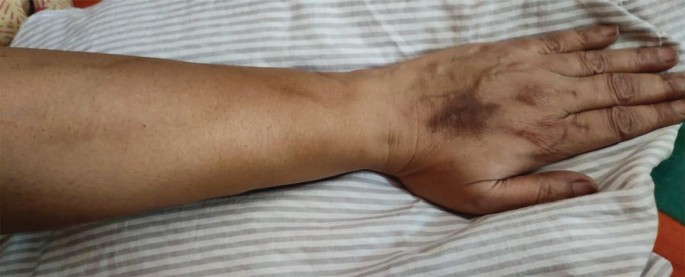

In [12]:
# Print metadata for randomly selected image 1
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

Random image path: images\0_normal\normal(b).jpeg
Image class: 0_normal
Image height: 459
Image width: 612


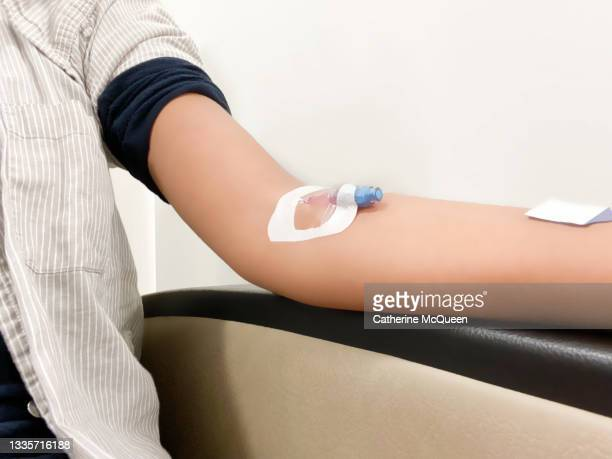

In [13]:
# Print metadata for randomly selected image 2
print(f"Random image path: {random_image_path2}")
print(f"Image class: {image_class2}")
print(f"Image height: {img2.height}") 
print(f"Image width: {img2.width}")
img2

As can be seen above, changing the seed value will select a different image from the dataset. If repeatability is required, the seed value should remain the same. 

## Splitting Dataset into Train, Validation and Test Sets
We will explore the use of the StratifiedShuffleSplit class from the scikit-learn library to see how we can randomly split the dataset while perserving the class distribution. Splitting the dataset this way is key when evaluation how the trained model performs on unseen data and to ensure it generalizes well and does is not overfitting.

In [14]:
# First lets split the dataset into a development and a testing set. The test set will be 25% of the total dataset
sss = StratifiedShuffleSplit(n_splits = 1, test_size= 0.25, random_state=100) 

# generates the indices for both the development and test sets
sss.get_n_splits(images,labels_int)  
dev_index, test_index = next(sss.split(images,labels_int))

# uses the indices generated above to create the development set
dev_images = images[dev_index]
dev_labels = labels_int[dev_index]

# uses the indices generated above to create the test set
test_images = images[test_index]
test_labels = labels_int[test_index] 

In [15]:
# Now lets split the development set into a training and validation set. The validation set will be 25% of the development set
sss2 = StratifiedShuffleSplit(n_splits = 1, test_size= 0.25, random_state=100)

# generates the indices for both the training and validation sets
sss2.get_n_splits(dev_images,dev_labels)
train_index, val_index = next(sss2.split(dev_images,dev_labels))

# uses the indices generated above to create the training set
train_images = images[train_index]
train_labels = labels_int[train_index]

# uses the indices generated above to create the validation set
val_images = images[val_index]
val_labels = labels_int[val_index] 

In [16]:
# Let's print the size of each set after splitting
print("Train set:", train_images.size)
print("Val set:", val_images.size)
print("Test set:", test_images.size)

Train set: 47
Val set: 16
Test set: 21


In [17]:
# Combines the images and their corresponding labels into three dictionaries (training, validation and testing sets)
train_set = {"X": train_images, "Y": train_labels}
val_set = {"X": val_images, "Y": val_labels}
test_set = {"X": test_images, "Y": test_labels}

## Exploring Transforms for data augmentation

Method to plot images

In [18]:
def plot_images(imgs, orig_img=None, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    with_orig=True if orig_img is not None else False

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False, figsize=(12, 12))
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set_ylabel(row_title[row_idx], rotation=0, labelpad=65)

    

### Exploring AutoAugment

Plotting auto augment policies to see the affect on a sample image

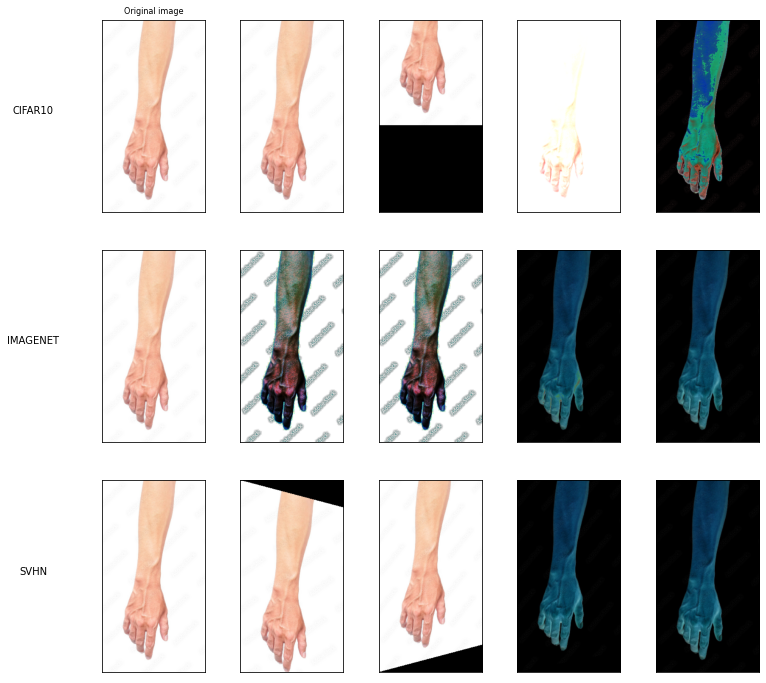

In [19]:
policies = [transforms.AutoAugmentPolicy.CIFAR10, transforms.AutoAugmentPolicy.IMAGENET, transforms.AutoAugmentPolicy.SVHN]
augmenters = [transforms.AutoAugment(policy) for policy in policies]
orig_img=Image.open("images/0_normal/normal 8.png").convert("RGB")

imgs = [
    [augmenter(orig_img) for _ in range(4)]
    for augmenter in augmenters
]
row_title = [str(policy).split('.')[-1] for policy in policies]
plot_images(imgs, orig_img=orig_img, row_title=row_title)

These policies seem to augment the image too much at times for the purposes of our classification, as color is an important feature.

### Exploring random transforms

Random transforms can change the image in various ways to hopefully help the model generalize better. In our case, since the data size is very limited, we will use transforms to prevent the model from overfitting as much as possible. More transforms can be found here https://pytorch.org/vision/main/auto_examples/plot_transforms.html

Plotting examples of random transforms on a sample image

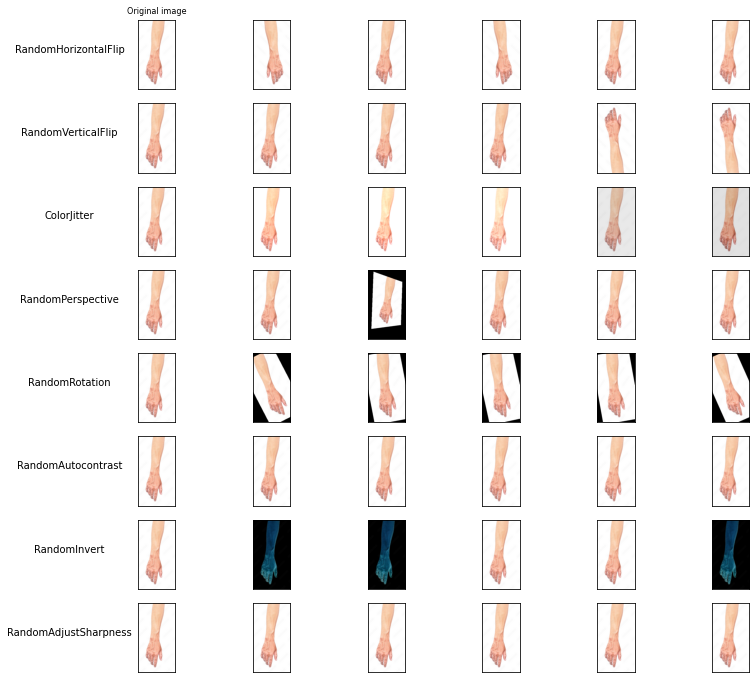

In [20]:
augmenters = [transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
              transforms.RandomPerspective(distortion_scale=0.4), transforms.RandomRotation(degrees=(0,30)), transforms.RandomAutocontrast(), transforms.RandomInvert(),
              transforms.RandomAdjustSharpness(sharpness_factor=2)]

imgs = [
    [augmenter(orig_img) for _ in range(5)]
    for augmenter in augmenters
]
row_title = [transform._get_name() for transform in augmenters]
plot_images(imgs, orig_img=orig_img, row_title=row_title)

From the above transforms, we will use all except for RandomInvert and RandomAutocontrast as they change the color too much, which is an important feature for our classification.

# Defining the experimental data

### Selecting Model

Selecting the pretrained model and weights. For our experiment, we will be using ResNet-18, which is a convolutional neural network which is 18 layers deep, and is trained on over a million images from the ImageNet database. There are larger models available with more parameters, but since our data size is very limited, we have chosen a relatively smaller model.

In [21]:
selected_model=resnet18
pretrained_weights=ResNet18_Weights.IMAGENET1K_V1

### Defining the transforms

For training, we will first augment the data with random transformation followed by the same standard transforms used in the training of ResNet18. For testing, only the ResNet18 transforms will be applied.

In [22]:
torchvision_transform = torch.nn.Sequential(transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), transforms.ColorJitter(brightness=0.2,saturation=0.2, contrast=0.2),
              transforms.RandomRotation(degrees=(0,30)), transforms.RandomPerspective(distortion_scale=0.4), transforms.RandomAdjustSharpness(sharpness_factor=2),
              pretrained_weights.transforms())


torchvision_transform_test = pretrained_weights.transforms()

Define training, validation and testings Datasets and Dataloaders

In [23]:
train_dataset = TorchVisionDataset(train_set, transform=torchvision_transform)
val_dataset = TorchVisionDataset(val_set, transform=torchvision_transform)
test_dataset = TorchVisionDataset(test_set, transform=torchvision_transform_test)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size= 32, shuffle = True, num_workers= 0)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size= 32, num_workers= 0)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size= 32, num_workers= 0)

## Dataset statistics

In [24]:
def get_dataset_stats(data_loader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data in data_loader:
        data = data[0]  # Get the images to compute the stgatistics
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean, std

print(get_dataset_stats(trainloader))

(tensor([0.2516, 0.0356, 0.1591]), tensor([1.1022, 1.0075, 0.9957]))


In [25]:
train_iterator = iter(trainloader)
train_batch = next(train_iterator)

print(train_batch[0].size())
print(train_batch[1].size())

torch.Size([32, 3, 224, 224])
torch.Size([32])


## Lets visualize some of the transformed images

Note that the visualization of the transformed images won't be accurate, as they are normalized for the ResNet18 model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


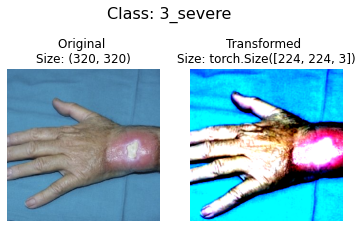

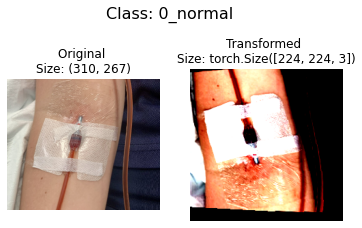

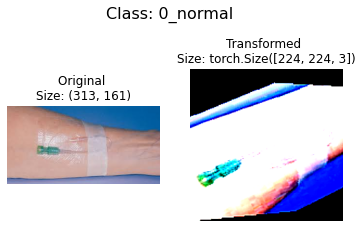

In [26]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path).convert("RGB") as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=torchvision_transform, 
                        n=3)

# Defining Model
Defining model extension of nn.Module which will load the selected model's feature extractor and add a linear classifier layer on top.  
This class will load the selected model's pretrained weights if transfer is true. The model will also fix the feature extractor layer and not train the parameters if fixed_feature_extractor is true.

In [27]:
class Model(nn.Module):
    def __init__(self,  num_classes, input_shape, transfer=False, fixed_feature_extractor=False):
        super().__init__()

        self.transfer = transfer
        self.num_classes = num_classes
        self.input_shape = input_shape
        
        # loading pretrained_weights if transfer is True
        self.feature_extractor =  selected_model(weights=(pretrained_weights if transfer else None))

        if fixed_feature_extractor:
            # layers are frozen by using eval()
            self.feature_extractor.eval()
            # freeze params
            for param in self.feature_extractor.parameters():
                param.requires_grad = False

        n_features = self._get_conv_output(self.input_shape)
        self.classifier = nn.Linear(n_features, num_classes)

    def _get_conv_output(self, shape):
        batch_size = 1
        tmp_input = torch.autograd.Variable(torch.rand(batch_size, *shape))

        output_feat = self.feature_extractor(tmp_input) 
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

    # will be used during inference
    def forward(self, x):
       x = self.feature_extractor(x)
       x = x.view(x.size(0), -1)
       x = self.classifier(x)
       
       return x


Creating a model which will load the pretrained weights and fix the feature extractor parameters, only training the classifier.

In [28]:
net = Model(4, (3,224,224), transfer=True, fixed_feature_extractor=True)
net.to(device)

Model(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

Defining the criterion, optimizer, and scheduler


We can measure the classification quality of the model via cross-entropy loss, using the Adam optimizer with a learning rate of 0.001.

In [29]:
# CrossEntropyLoss for classification
criterion = nn.CrossEntropyLoss()

# selecting optimizer
optimizer = torch.optim.AdamW(net.parameters(), lr = 0.001)

# exponential schedule will multiply the learning rate by gamma after each epoch
scheduler = ExponentialLR(optimizer, gamma=0.90)

## Training Model

In [30]:
nepochs = 30
PATH = 'EV_net.pth' # Path to save the best model

best_loss = 1e+20
for epoch in range(nepochs):  # loop over the dataset multiple times
    # Training Loop
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f'{epoch + 1},  train loss: {train_loss / (i+1):.3f},', end = ' ')
    scheduler.step()
    
    val_loss = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
        print(f'val loss: {val_loss / (i+1):.3f}')
        
        # Save best model
        if val_loss < best_loss:
            print("Saving model")
            torch.save(net.state_dict(), PATH)
            best_loss = val_loss
        
print('Finished Training')

1,  train loss: 2.239, val loss: 2.069
Saving model
2,  train loss: 1.730, val loss: 1.592
Saving model
3,  train loss: 1.375, val loss: 1.591
Saving model
4,  train loss: 1.329, val loss: 1.147
Saving model
5,  train loss: 1.082, val loss: 0.757
Saving model
6,  train loss: 0.997, val loss: 0.799
7,  train loss: 0.978, val loss: 0.782
8,  train loss: 0.868, val loss: 0.928
9,  train loss: 0.850, val loss: 0.969
10,  train loss: 0.839, val loss: 0.824
11,  train loss: 0.719, val loss: 0.922
12,  train loss: 0.651, val loss: 0.776
13,  train loss: 0.639, val loss: 0.994
14,  train loss: 0.618, val loss: 0.739
Saving model
15,  train loss: 0.499, val loss: 0.790
16,  train loss: 0.569, val loss: 0.636
Saving model
17,  train loss: 0.552, val loss: 0.950
18,  train loss: 0.556, val loss: 0.850
19,  train loss: 0.558, val loss: 0.957
20,  train loss: 0.585, val loss: 0.915
21,  train loss: 0.492, val loss: 0.837
22,  train loss: 0.477, val loss: 0.794
23,  train loss: 0.558, val loss: 0.84

Load the best model found to be used for testing

In [31]:

net = Model(4, (3,224,224), False)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Model Evaluation and Accuracy

In [32]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')

Accuracy of the network on the test images: 47.61904761904762 %


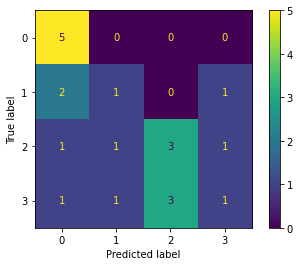

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(labels, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

plt.show()

The final testing model accuracy is 47.6%, which is significantly higher than the baseline of 30% achieved by blind guessing. While this does show the model was able to generalize to the testing data, it is hard to tell how good the model really is with such a limited data set. To improve this classifier, additional data is highly recommended to improve results. 